In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize
from ALLCools.plot import *
import re

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [3]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [4]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell tidy data

In [5]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Inh']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Motif information

In [6]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')

for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


In [7]:
from ALLCools.motif.utilities import *

In [8]:
motif_pfms = meme_to_pfm_dict(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant_pfms.meme'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ALLCools/motif/utilities.py:138: RuntimeWarning: divide by zero encountered in log2
  information_content = (pfm * np.log2(pfm / 0.25)).sum(axis=1)


## Tree

In [10]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.linkage.csv',
    header=0,
    index_col=0).reset_index(drop=True)
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)

## Gene Assignment

In [10]:
gene_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/NodeGeneResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Motif Assignment

In [11]:
motif_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMR/NodeMotifResults.msg'
)

## Trace related motifs

In [12]:
def get_node_path(start_node):
    int_to_cluster = {i: cluster for i, cluster in zip(dendro['leaves'], dendro['ivl'])}
    if start_node <= max(int_to_cluster.keys()):
        cluster = int_to_cluster[start_node]
    else:
        # take any child
        cluster = list(node_dict[start_node]['left'])[0]
        
    nodes = [start_node]
    for k, v in node_dict.items():
        if k < start_node:
            continue
        else:
            if cluster in (v['left'] | v['right']):
                nodes.append(k)
    node_path = sorted(set(nodes), reverse=True)
    return node_path


In [13]:

def get_node_motifs(node):
    motif_rs = motif_assignment.loc[node]
    left = motif_rs[motif_rs > rs_cutoff]
    right = motif_rs[motif_rs < -rs_cutoff]
    return left, right

In [14]:
def plot_node(node):
    left_motif, right_motif = get_node_motifs(node)

    left_motif_info = motif_gene_anno.loc[left_motif.index]
    left_motif_info['rs'] = left_motif
    left_motif_info.sort_values('motif_group', inplace=True)

    right_motif_info = motif_gene_anno.loc[right_motif.index]
    right_motif_info['rs'] = right_motif
    right_motif_info.sort_values('motif_group', inplace=True)

    node_genes = gene_assignment.loc[node]

    scale = 1.2
    max_rows = max(left_motif_info.shape[0], right_motif_info.shape[0])
    head_size = 2
    motif_height = 2
    gs_rows = head_size + int(max_rows * motif_height)
    gs_cols = 50 + 2

    fig = plt.figure(figsize=(0.1 * gs_cols * scale, 0.1 * gs_rows * scale),
                     dpi=300)
    gs = fig.add_gridspec(gs_rows, gs_cols)

    left_cmap = sns.light_palette("salmon", as_cmap=True)
    right_cmap = sns.light_palette("steelblue", as_cmap=True)

    ax_node = fig.add_subplot(gs[0, 20:30])

    ax = ax_node
    ax.plot((0.25, 0.25, 0.75, 0.75), (0, 1, 1, 0),
            c='gray',
            clip_on=False,
            transform=ax.transAxes)
    ax.scatter(x=(0.25, 0.5, 0.75),
               y=(0, 1, 0),
               clip_on=False,
               c=['salmon', 'gray', 'steelblue'],
               zorder=10,
               transform=ax.transAxes,
               s=node_size)
    ax.text(x=0.5,
            y=2,
            va='center',
            ha='center',
            transform=ax.transAxes,
            s=node,
            fontsize=labelsize)
    ax.axis('off')

    for i, (motif_id, row) in enumerate(left_motif_info.iterrows()):
        motif_pfm = motif_pfms[motif_id]
        motif_length = motif_pfm.shape[0]
        ax = fig.add_subplot(
            gs[int(i * motif_height +
                   head_size):int((i + 1) * motif_height +
                                  head_size), (24 - motif_length):24])
        plot_pfm(motif_pfm, ax)
        ax.set(xticks=[], yticks=[])
        sns.despine(ax=ax, left=True)
        ax.text(1,
                0.5,
                row['gene_names'] + ' ' + str(row['Family']) + ' ' +
                str(row['SubFamily']) + ' ' + f"{row['rs']:.2f}",
                ha='right',
                va='center',
                fontsize=labelsize,
                transform=ax.transAxes)

    for i, (motif_id, row) in enumerate(right_motif_info.iterrows()):
        motif_pfm = motif_pfms[motif_id]
        motif_length = motif_pfm.shape[0]
        ax = fig.add_subplot(gs[int(i * motif_height +
                                    head_size):int((i + 1) * motif_height +
                                                   head_size), 26:26 +
                                motif_length])
        plot_pfm(motif_pfm, ax)
        ax.set(xticks=[], yticks=[])
        sns.despine(ax=ax, left=True)
        ax.text(0,
                0.5,
                row['gene_names'] + ' ' + str(row['Family']) + ' ' +
                str(row['SubFamily']) + ' ' + f"{row['rs']:.2f}",
                ha='left',
                va='center',
                fontsize=labelsize,
                transform=ax.transAxes)
    return fig

In [15]:
top_n_tf = 4
top_n_other = 8
hard_cutoff = 0.3
max_y = 12
node_size = 20
line_space = 1.2
hue_norm = (0.3, 0.8)

In [17]:
rs_cutoff = 0.5
node_path = get_node_path(95)
node_path

[144, 142, 141, 135, 125, 104, 95]

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


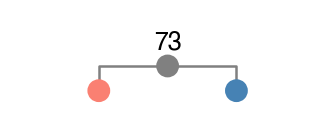

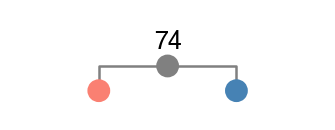

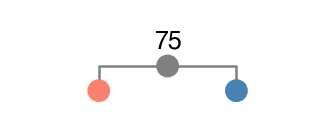

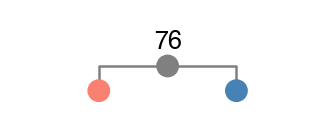

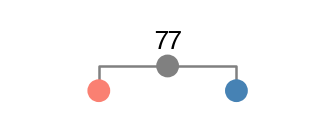

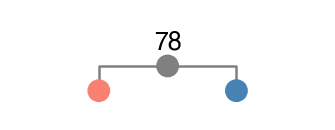

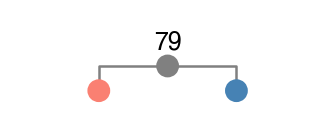

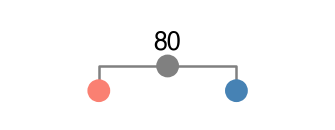

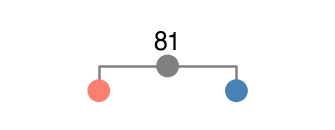

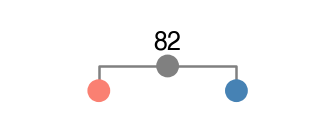

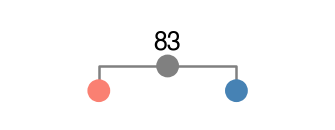

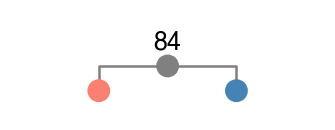

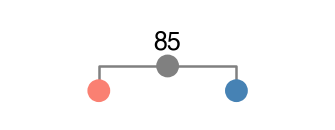

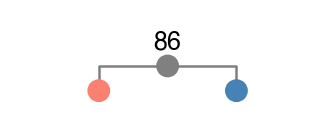

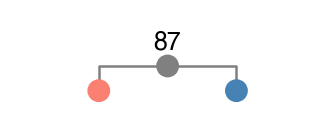

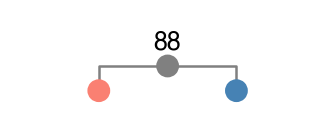

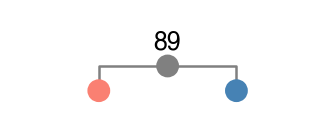

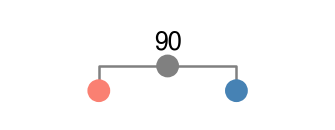

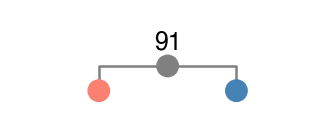

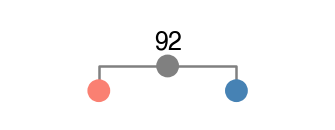

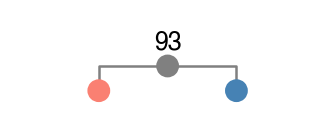

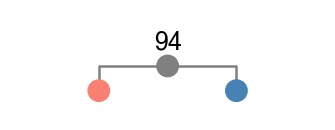

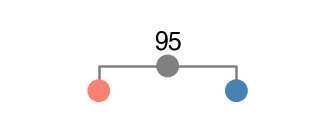

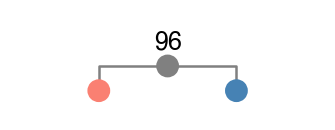

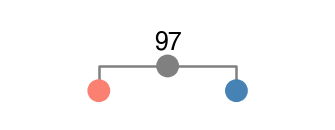

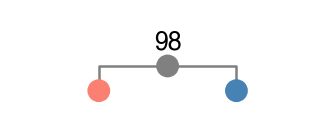

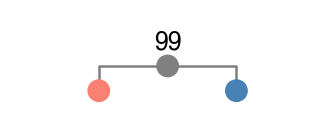

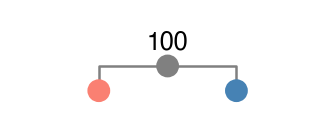

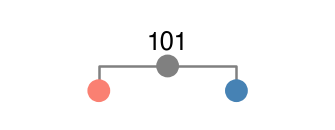

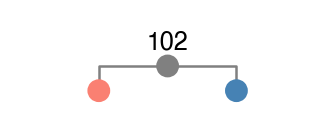

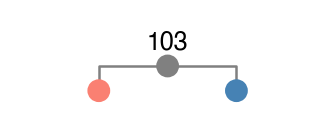

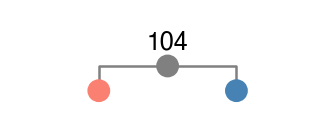

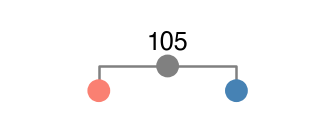

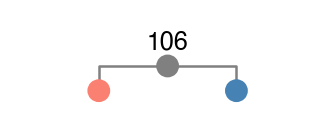

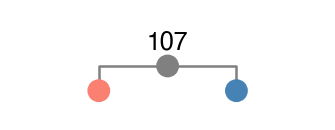

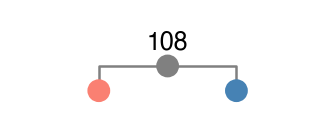

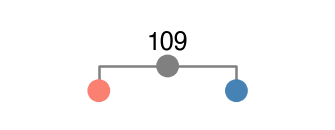

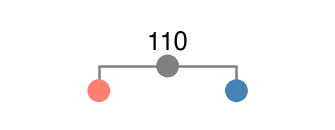

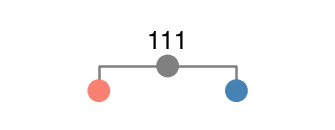

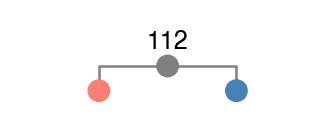

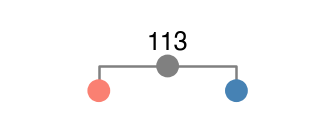

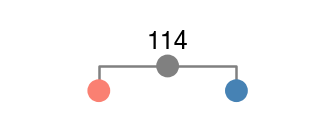

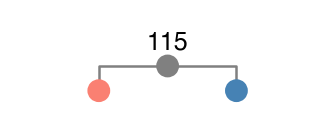

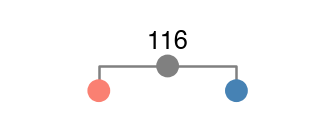

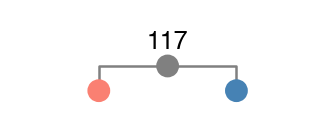

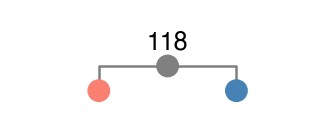

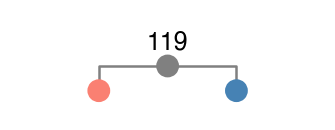

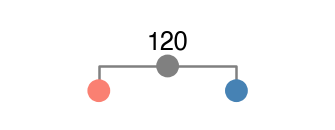

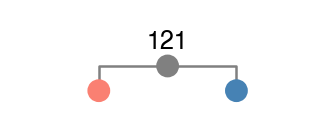

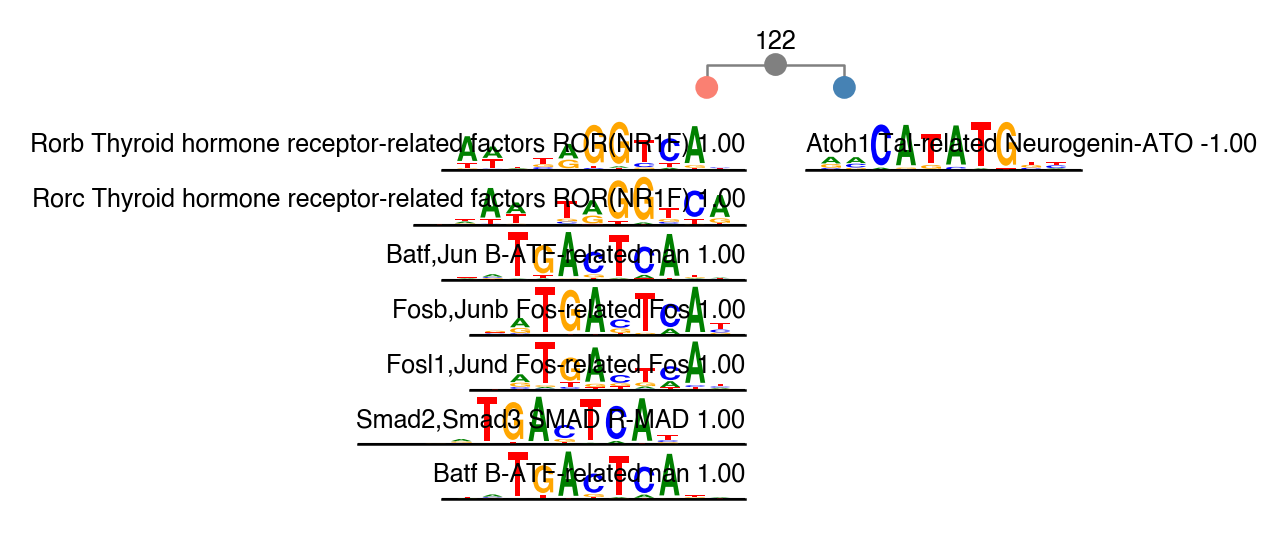

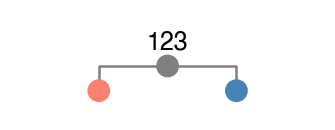

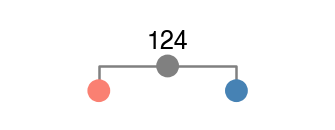

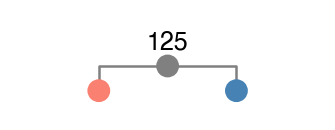

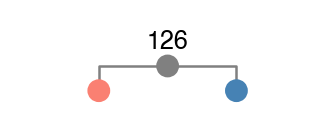

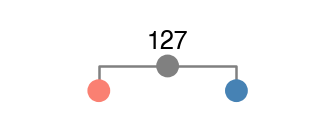

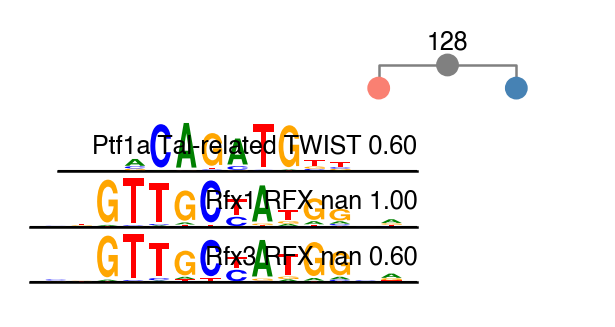

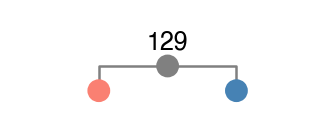

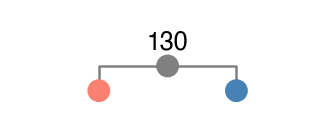

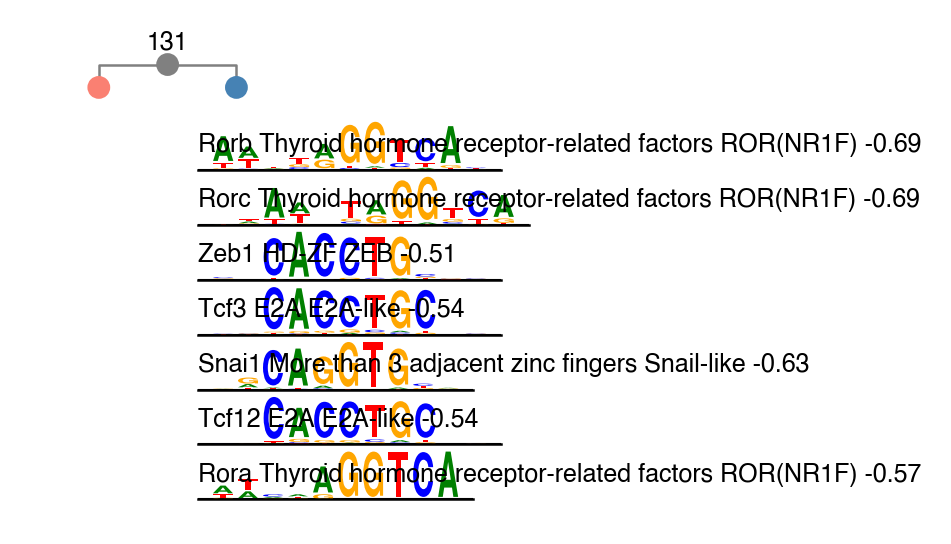

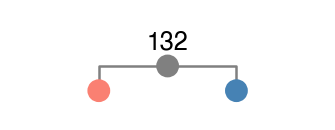

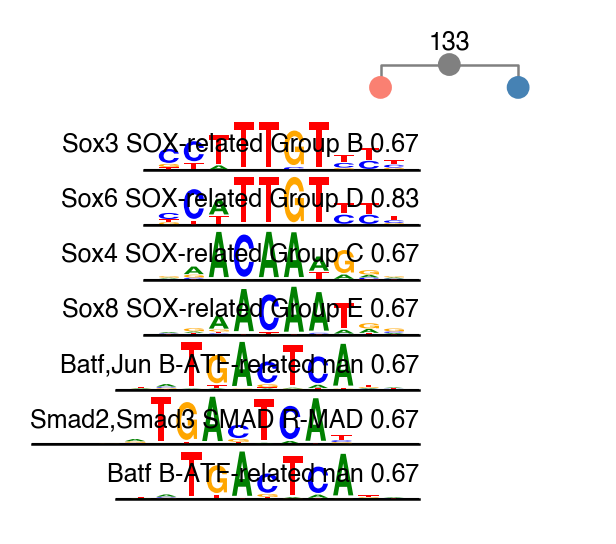

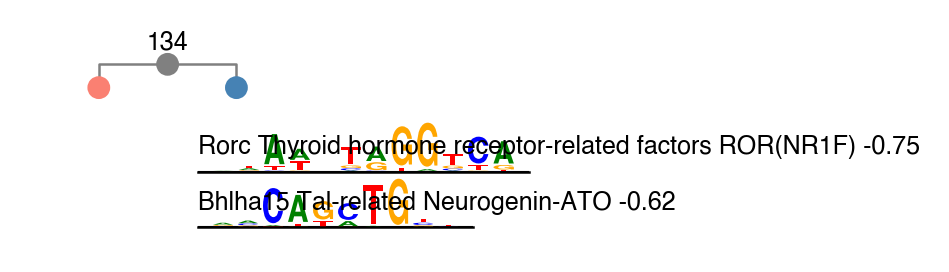

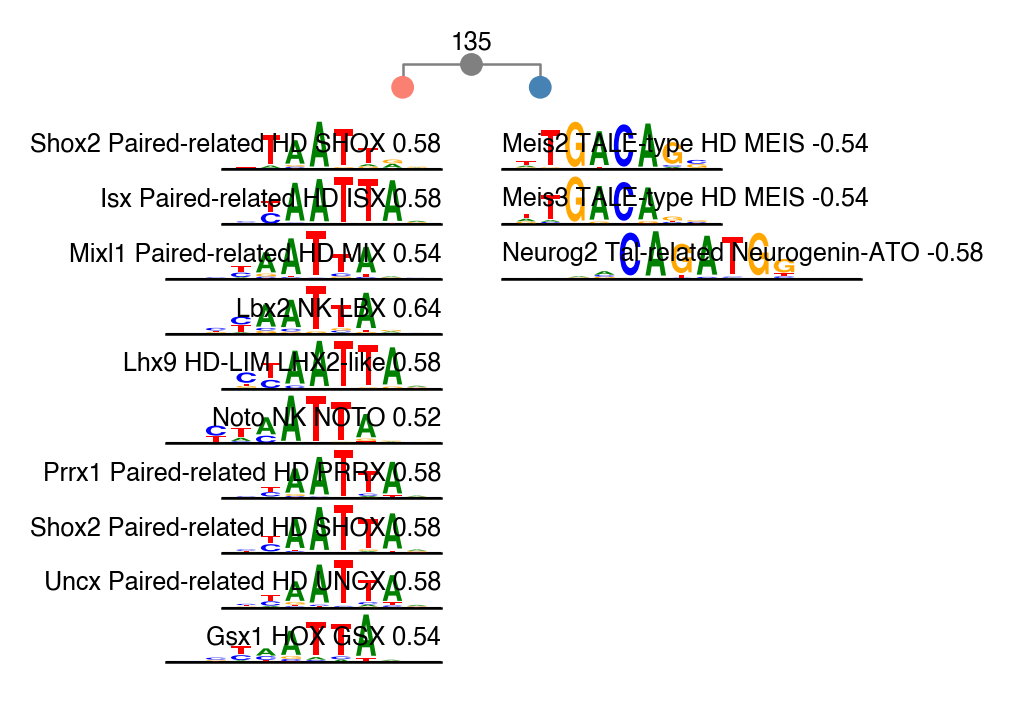

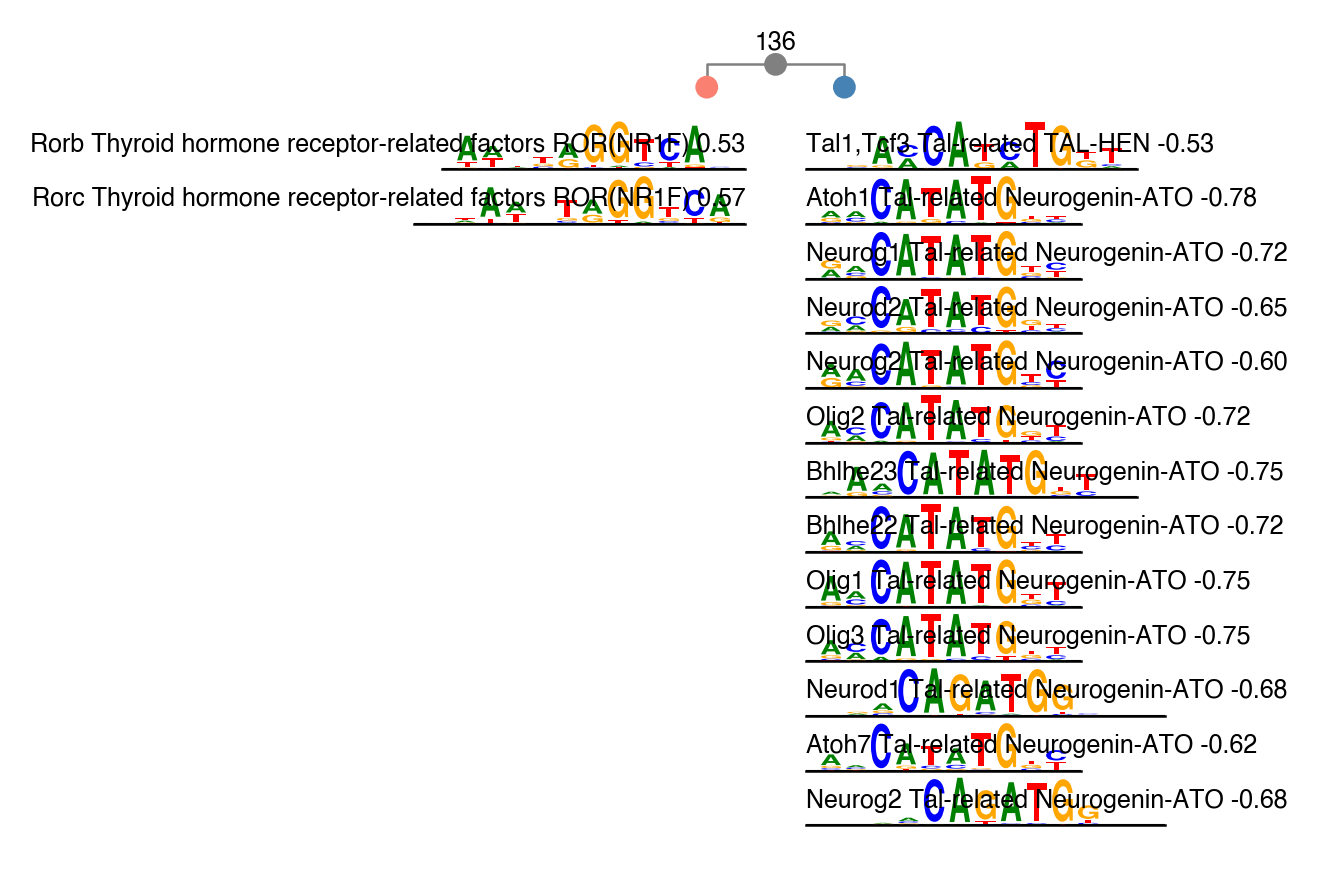

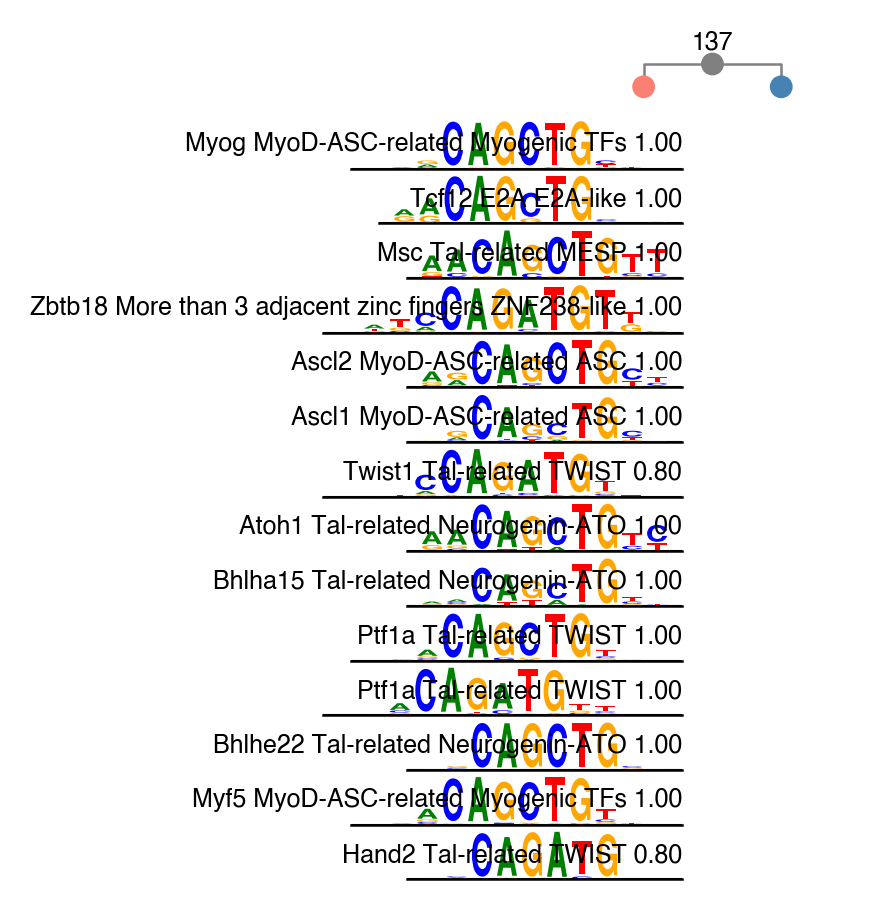

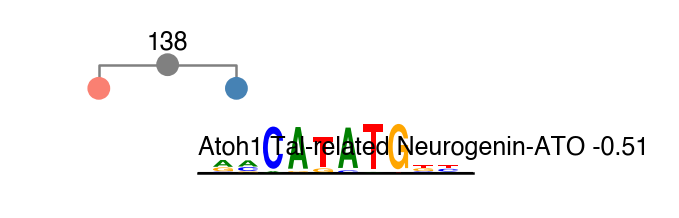

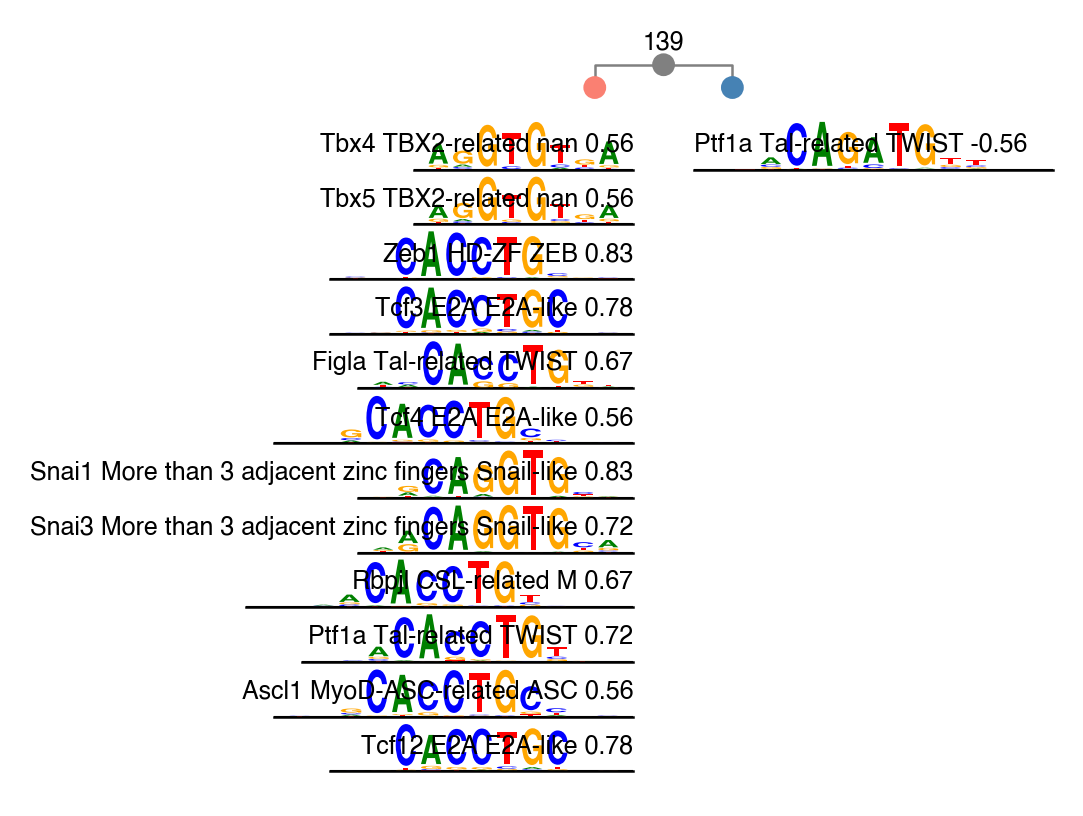

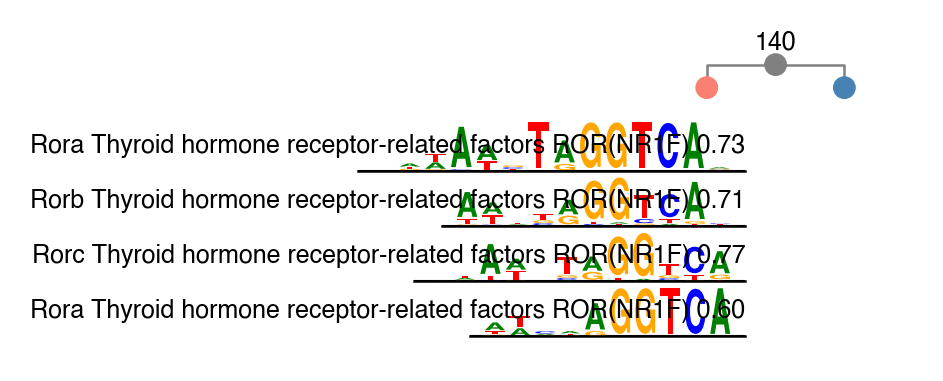

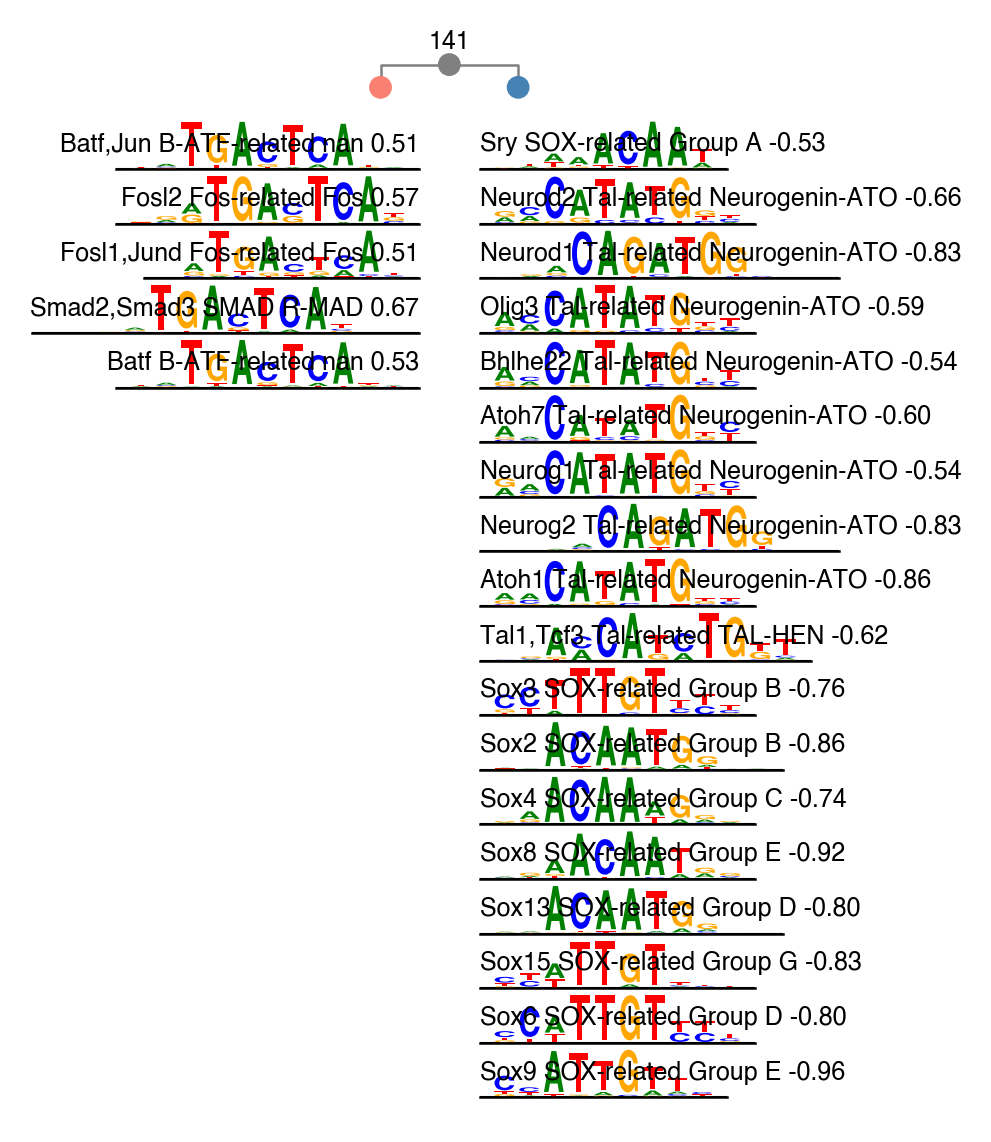

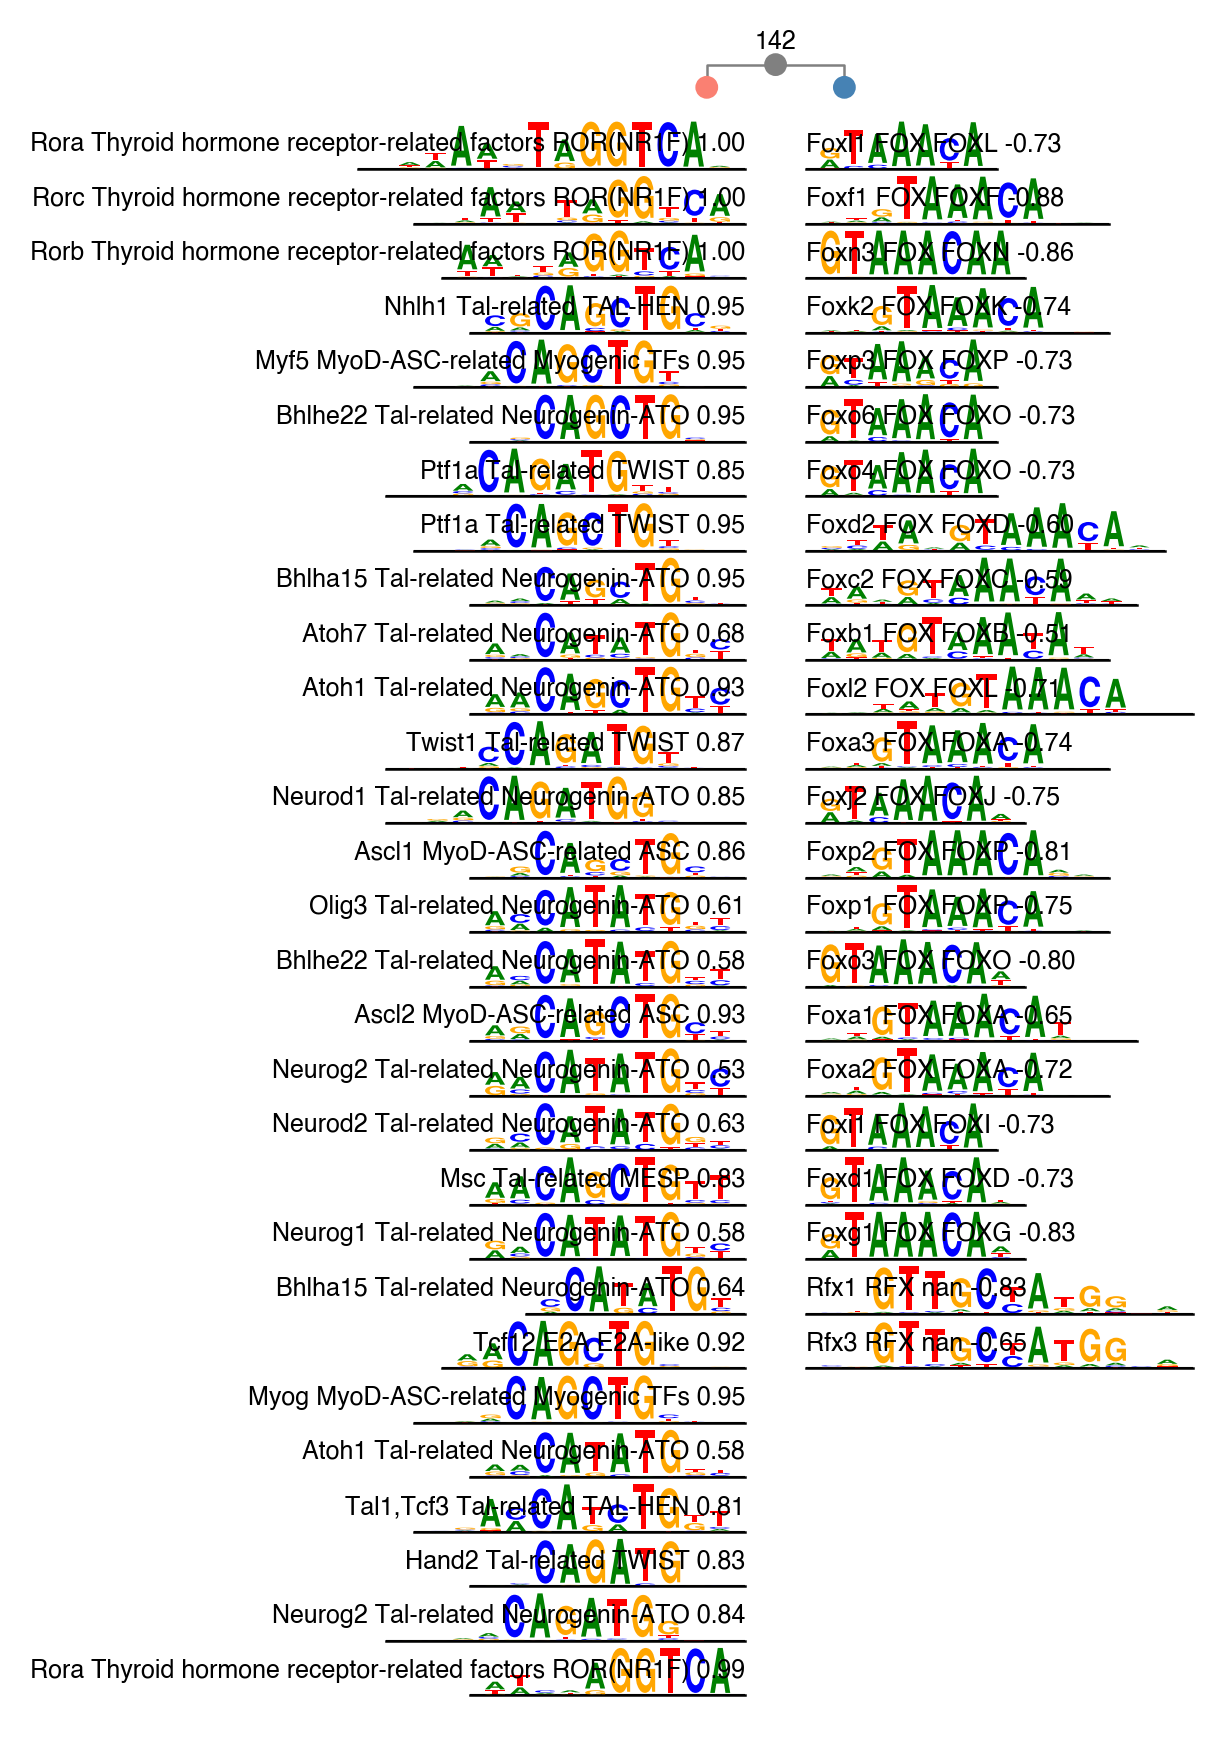

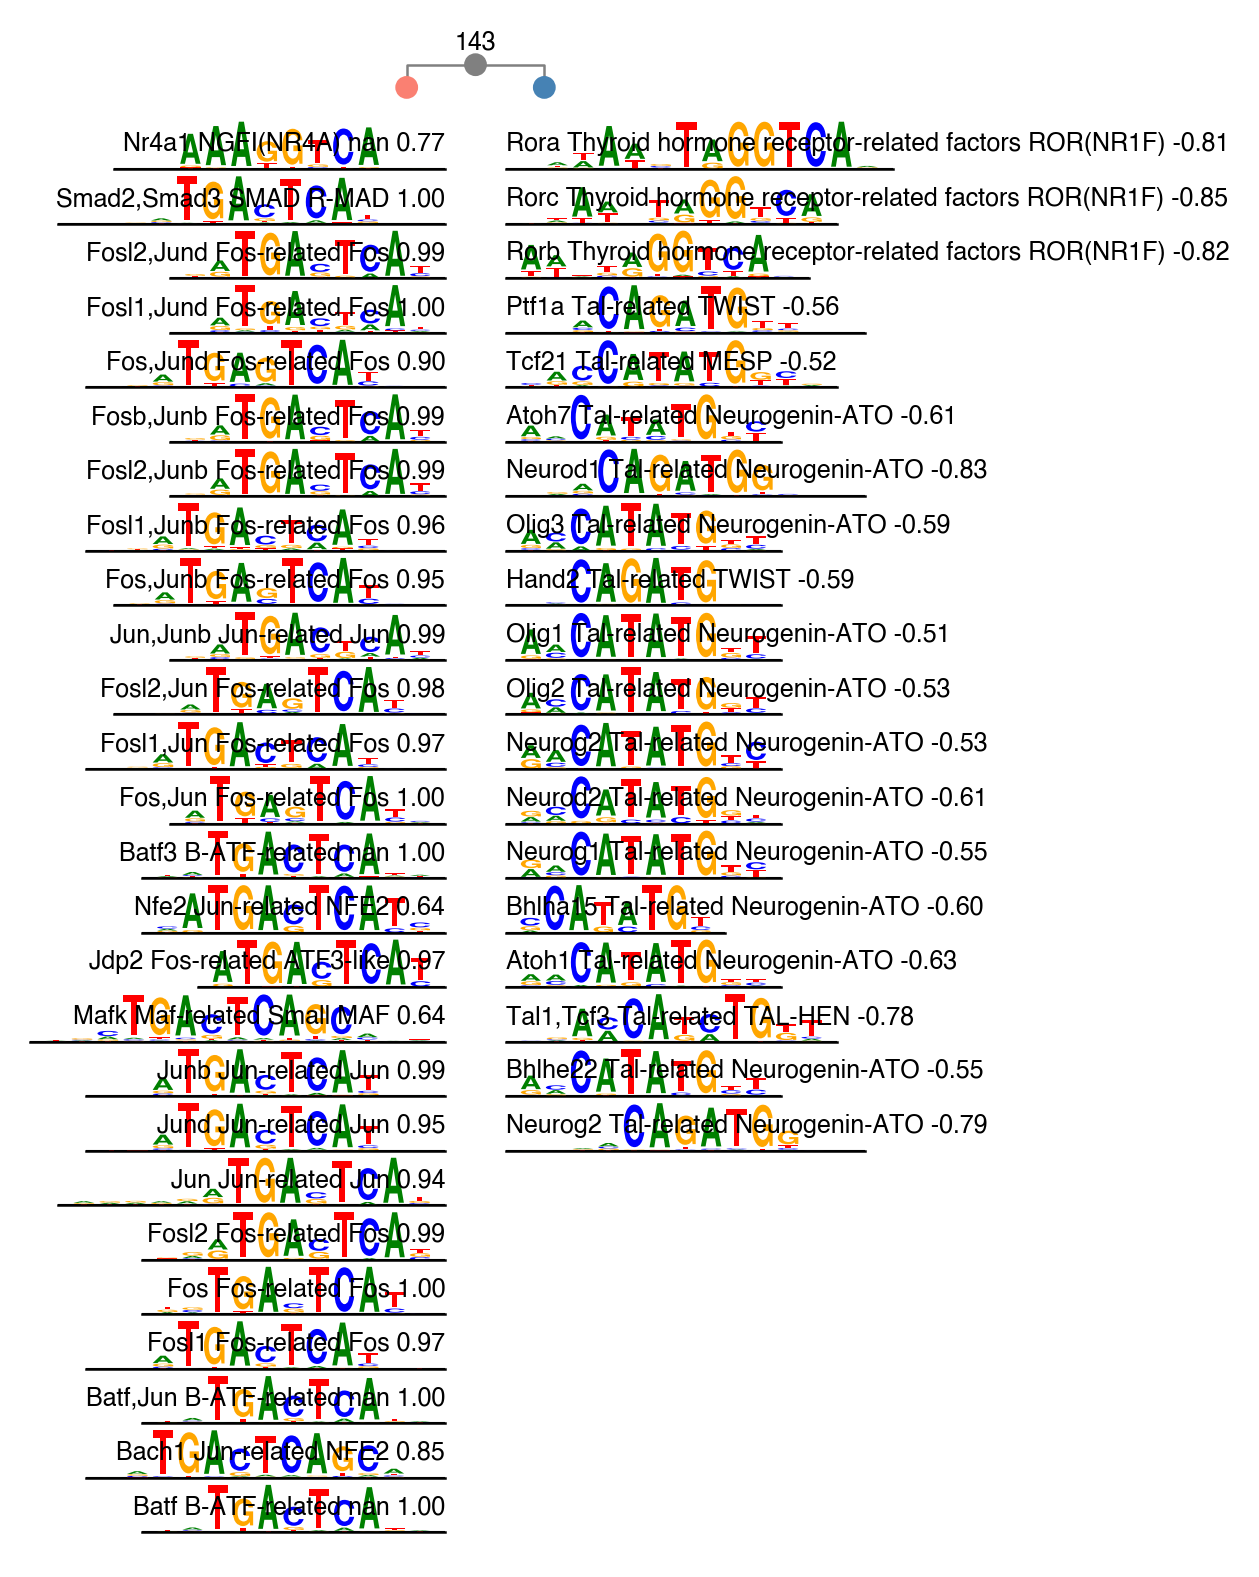

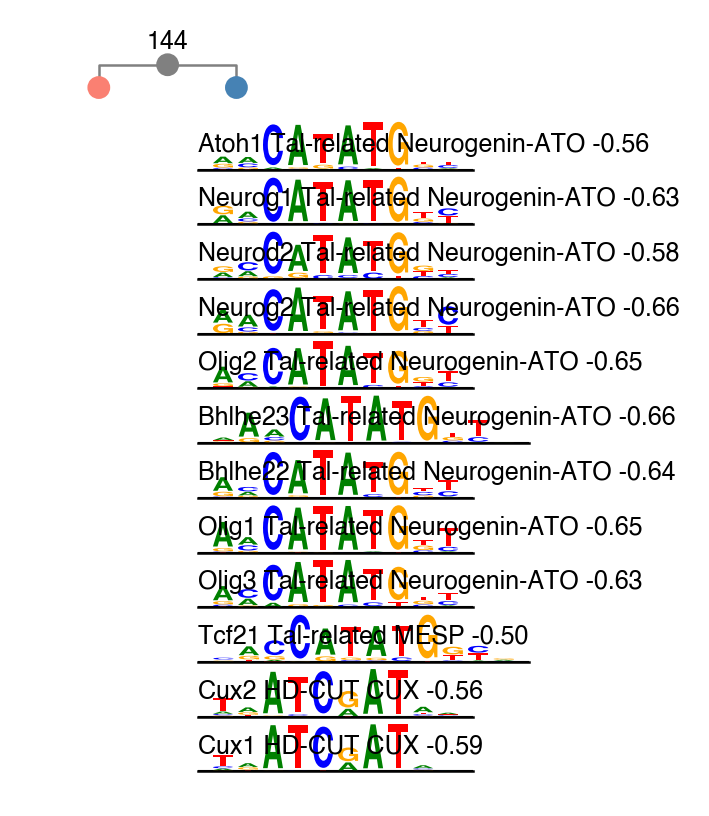

In [18]:
node_related_tf_dir = 'NodeTF'
pathlib.Path(node_related_tf_dir).mkdir(exist_ok=True)

for node in node_dict.keys():
    fig = plot_node(node)
    fig.savefig(f'{node_related_tf_dir}/{node}.pdf')